**Detección de Minería a Cielo Abierto en Imagenes Satelitales**

Presentado por: Steven Parra Giraldo

**Inicialmente, se deben subir los archivos adjuntos a Drive y luego establecer una conexión de Colab con Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive

Mounted at /content/gdrive
/content/gdrive


**Nos dirigimos a la carpeta de drive que contiene los archivos**

In [235]:
%cd /content/gdrive/My Drive/Proyecto_Final_ML

/content/gdrive/My Drive/Proyecto_Final_ML


Se importan librerias necesarias

In [322]:
from __future__ import print_function
from pyimagesearch.rgbhistogram import RGBHistogram
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import glob
import cv2

**Método que permite crear la máscara de las predicciones**

In [323]:
def create_blank(width, height, rgb_color=(0, 0, 0)):
    """Create new image(numpy array) filled with certain color in RGB"""
    # Crea una imagen 
    image = np.zeros((height, width, 3), np.uint8)

    # Dado que OpenCV usa BGR, convierta el color primero
    color = tuple(reversed(rgb_color))
    # Rellenar imagen con color
    image[:] = color

    return image

In [324]:
# Almacenar las rutas de las imagenes y mascaras
imagePaths = sorted(glob.glob("/content/gdrive/My Drive/Proyecto_Final_ML/dataset/images" + "/*.jpg"))
maskPaths = sorted(glob.glob("/content/gdrive/My Drive/Proyecto_Final_ML/dataset/masks" + "/*.jpg"))

# Inicializar vector de caracteristicas y salidas deseadas
data = []
target = []

# Se inicia un descriptor, en este caso es un histograma RGB de 8 bits por cada canal
desc = RGBHistogram([8, 8, 8])

In [325]:
# Iniciar bucle para extraer las caracteristicas de las regiones de interes (ROI)
for (imagePath, maskPath) in zip(imagePaths, maskPaths):
    # Leer imagenes y mascaras, convertir las mascaras a escala de grises
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Extraer las caracteristicas de la imagen (Histograma de Regiones de interes)
    features = desc.describe(image, mask)

    # Actualizar lista de caracteristicas y la salida deseada
    data.append(features)
    target.append(imagePath.split("_")[-2])

In [326]:
# Guardar los Targets como String y luego codificarlos en valores Enteros
targetNames = np.unique(target)
print(targetNames)
le = LabelEncoder()
target = le.fit_transform(target)
print(target)

['mineria' 'normal']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]


In [327]:
# Dividir el dataset en datos de entrenamiento (70%) y validacion (30%) 
(trainData, testData, trainTarget, testTarget) = train_test_split(data, target, stratify=target,
    test_size = 0.3, random_state = 42)


print("Train Data Shape: ", np.shape(trainData))
print("Train Target Shape: ", np.shape(trainTarget))
print("Test Data Shape: ", np.shape(testData))
print("Test Target Shape: ", np.shape(testTarget))

Train Data Shape:  (82, 512)
Train Target Shape:  (82,)
Test Data Shape:  (36, 512)
Test Target Shape:  (36,)


**Modelo KNN para Clasificación**

Inicialmente se prueba con el modelo más básico para clasificación 

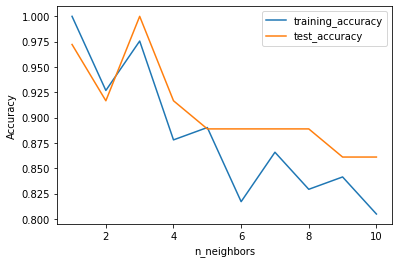

In [328]:
# Entrenar Clasificador

#Arreglos que almacenan resultados de las metricas
training_accuracy=[]
test_accuracy=[]

#va a hacer ciclos entre 1 y 10 vecinos
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
  #construye el modelo
  clf= KNeighborsClassifier(n_neighbors=n_neighbors)
  clf.fit(trainData, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(clf.score(trainData, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(clf.score(testData, testTarget))

plt.plot(neighbors_settings, training_accuracy, label= "training_accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()





**Según el analisis de complejidad, el mejor parámetro es cuando se tienen 2 vecinos**

In [329]:
clf_knn= KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(trainData, trainTarget)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [330]:
# Evaluamos el modelo con el reporte de Scikit Learn
print(classification_report(testTarget, clf_knn.predict(testData),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       0.86      1.00      0.92        18
      normal       1.00      0.83      0.91        18

    accuracy                           0.92        36
   macro avg       0.93      0.92      0.92        36
weighted avg       0.93      0.92      0.92        36



**Con KNN se logra obtener una Precision promedio de aproximadamente 93%, por lo tanto, se procede a probar con otro modelo**

**Modelo de Regresión Logistica**

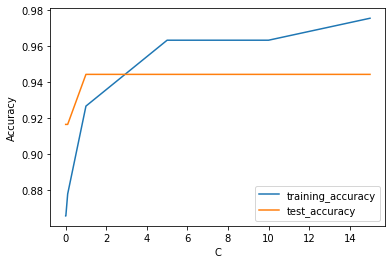

In [331]:
training_accuracy=[]
test_accuracy=[]

#Se harán 4 ciclos, cada uno para el parámetro C
c_settings = [0.001, 0.01, 0.1, 1, 5, 10, 15]

for c in c_settings:
  #construye el modelo
  logreg= LogisticRegression(C=c)
  logreg.fit(trainData, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(logreg.score(trainData, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(logreg.score(testData, testTarget))

plt.plot(c_settings, training_accuracy, label= "training_accuracy")
plt.plot(c_settings, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

**Según el analisis de complejidad, el mejor valor para el parámetro C es 3**

In [332]:
logreg= LogisticRegression(C=3)
logreg.fit(trainData, trainTarget)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [333]:
# Evaluamos el modelo con el reporte de Scikit Learn
print(classification_report(testTarget, logreg.predict(testData),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       0.94      0.94      0.94        18
      normal       0.94      0.94      0.94        18

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36



**Con Regresión Logistica se logra obtener una Precision promedio de aproximadamente 94%, mejorando en 1 punto porcentual a KNN, sin embargo, se probaran otros modelos**

**Modelo de Bosques Aleatorios**

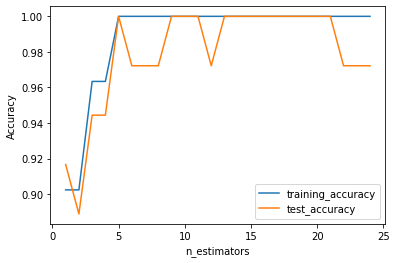

In [334]:
training_accuracy=[]
test_accuracy=[]

#Se harán 25 ciclos, cada uno para el parámetro estimadores
n_estimators = range(1, 25)

for c in n_estimators:
  #construye el modelo
  forest= RandomForestClassifier(n_estimators=c, max_features=512, random_state=84)
  forest.fit(trainData, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(forest.score(trainData, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(forest.score(testData, testTarget))

plt.plot(n_estimators, training_accuracy, label= "training_accuracy")
plt.plot(n_estimators, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()

**Se logra identificar que el mejor parámetro es un estimador de 5**

In [335]:
forest= RandomForestClassifier(n_estimators=5, max_features=512, random_state=84)
forest.fit(trainData, trainTarget)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=512,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=84, verbose=0,
                       warm_start=False)

In [336]:
# Evaluamos el modelo con el reporte de Scikit Learn
print(classification_report(testTarget, forest.predict(testData),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       1.00      1.00      1.00        18
      normal       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



**Con el Bosque Aleatorio se logra obtener una precisión de un 100%**

Por lo que se convierte en el mejor modelo hasta ahora.

**Modelo Máquina de Soporte Vectorial**

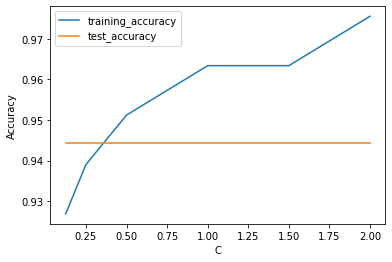

In [337]:
training_accuracy=[]
test_accuracy=[]

#Se harán 25 ciclos, cada uno para el parámetro estimadores
c_values = [0.125, 0.25, 0.5, 1.0, 1.5, 2.0]

for c in c_values:
  #construye el modelo
  svm= LinearSVC(C=c)
  svm.fit(trainData, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(svm.score(trainData, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(svm.score(testData, testTarget))

plt.plot(c_values, training_accuracy, label= "training_accuracy")
plt.plot(c_values, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

**El valor de regularización ideal es de aproximadamente 0.375**

In [338]:
svm = LinearSVC(C=0.375)
svm.fit(trainData, trainTarget)

LinearSVC(C=0.375, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [339]:
# Evaluamos el modelo con el reporte de Scikit Learn
print(classification_report(testTarget, svm.predict(testData),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       0.94      0.94      0.94        18
      normal       0.94      0.94      0.94        18

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36



**Con el modelo de Maquina de soporte Vectoria se obtiene un resultado de 94% de precisión. Cómo se pudo observar, el módelo que mejor se adapta al presente problema de clasificación de imágenes es el de Bosques Aleatorios**

***Predicciones***

Features shape:  (512,)
Esta Imagen Satelital es de MINERIA


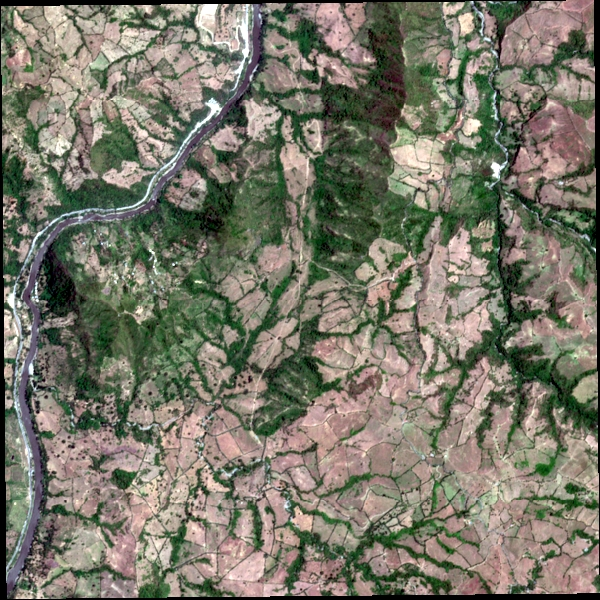

In [340]:
from google.colab.patches import cv2_imshow
# load the image and mask  (83.jpg)
image = cv2.imread("/content/gdrive/My Drive/Proyecto_Final_ML/test/83.jpg")
# Create new blank 300x300 red image
width1, height1 = image.shape[:2]

color = (255, 255, 255)
mask = create_blank(width1, height1, rgb_color=color)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# describe the image
features = desc.describe(image, mask)

print("Features shape: ", np.shape(features))

# predict what type of satellite image is
mineria = le.inverse_transform(forest.predict([features]))[0]
print("Esta Imagen Satelital es de {}".format(mineria.upper()))
cv2_imshow(image)


**La imagen anterior es un caso de Falso positivo, puesto que esta imagen no presenta patrones de minería, se usará Ingeniería de Características para intentar mejorar el rendimiento**

**Implementando Ingeniería de Características**

*Recordar los tamaños originales de los vectores de caracteristicas y target para entrenamiento y validación*

In [341]:
print("Train Data Shape: ", np.shape(trainData))
print("Train Target Shape: ", np.shape(trainTarget))
print("Test Data Shape: ", np.shape(testData))
print("Test Target Shape: ", np.shape(testTarget))


Train Data Shape:  (82, 512)
Train Target Shape:  (82,)
Test Data Shape:  (36, 512)
Test Target Shape:  (36,)


**PCA Standard Scaler sobre 2 componentes principales**

In [365]:
# Se entrena el StandardScaler con el conjunto de train y luego se aplica la transformación al conjunto de features de train y test 

from sklearn.preprocessing import StandardScaler #import el escalador de datos 
scaler = StandardScaler() #asigno la funcion que hace el escalamiento a la variable scaler

scaler.fit(trainData) # aplicalo el escalamiento a conjunto de entrenamiento

trainData_scaled = scaler.transform(trainData) # creo el conjunto de datos de entrenamiento escalados
testData_scaled = scaler.transform(testData)  # creo el conjunto de datos de test escalados


from sklearn.decomposition import PCA #Se importa PCA para hacer reduccionalidad de dimension

# Se mantienen los dos componentes principales de los datos
pca = PCA(n_components=2) #Se indica cuantos componentes se usarán (2)
# Se entrena con el conjunto de datos de train
pca.fit(trainData_scaled)

# Se hace la tranformación a los dos componentes principales tanto para X_train como para X_test
trainData_pca = pca.transform(trainData_scaled)
testData_pca = pca.transform(testData_scaled)

#Se imprimen los tamaños de los arreglos para identificar la reducción de dimensión
print("Original X_train-shape: {}".format(str(trainData_scaled.shape)))
print("Reduced X_train-shape: {}".format(str(trainData_pca.shape)))
print("Original X_test-shape: {}".format(str(testData_scaled.shape)))
print("Reduced X_test_shape: {}".format(str(testData_pca.shape)))

# Se entrena un modelo de regresión linear estándar teniendo cómo entrada el uniforme:




Original X_train-shape: (82, 512)
Reduced X_train-shape: (82, 2)
Original X_test-shape: (36, 512)
Reduced X_test_shape: (36, 2)


**KNN Con PCA**

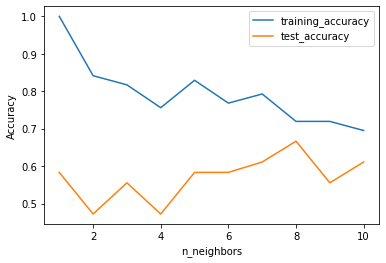

In [366]:
# Entrenar Clasificador

#Arreglos que almacenan resultados de las metricas
training_accuracy=[]
test_accuracy=[]

#va a hacer ciclos entre 1 y 10 vecinos
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
  #construye el modelo
  clf= KNeighborsClassifier(n_neighbors=n_neighbors)
  clf.fit(trainData_pca, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(clf.score(trainData_pca, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(clf.score(testData_pca, testTarget))

plt.plot(neighbors_settings, training_accuracy, label= "training_accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

**Definitivamente, este método de preprocesamiento no funcionó nada bien en comparación con las carácteristicas originales**

In [368]:
clf_knn= KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(trainData_pca, trainTarget)
print(classification_report(testTarget, clf_knn.predict(testData_pca),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       0.48      0.72      0.58        18
      normal       0.44      0.22      0.30        18

    accuracy                           0.47        36
   macro avg       0.46      0.47      0.44        36
weighted avg       0.46      0.47      0.44        36



**Regresión Logistica con PCA**

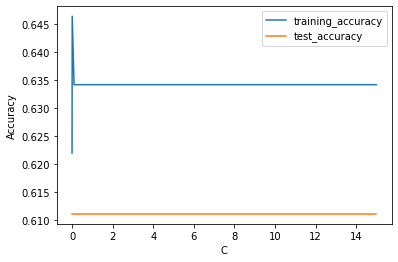

In [344]:
training_accuracy=[]
test_accuracy=[]

#Se harán 4 ciclos, cada uno para el parámetro C
c_settings = [0.001, 0.01, 0.1, 1, 5, 10, 15]

for c in c_settings:
  #construye el modelo
  logreg= LogisticRegression(C=c)
  logreg.fit(trainData_pca, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(logreg.score(trainData_pca, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(logreg.score(testData_pca, testTarget))

plt.plot(c_settings, training_accuracy, label= "training_accuracy")
plt.plot(c_settings, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

**Con Regresión Logistica Incluso los resultados son peores que KNN**

In [369]:
logreg= LogisticRegression(C=3)
logreg.fit(trainData_pca, trainTarget)
print(classification_report(testTarget, logreg.predict(testData_pca),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       0.59      0.72      0.65        18
      normal       0.64      0.50      0.56        18

    accuracy                           0.61        36
   macro avg       0.62      0.61      0.61        36
weighted avg       0.62      0.61      0.61        36



**Bosques Aleatorios con PCA**

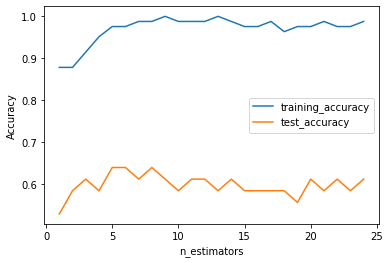

In [345]:
training_accuracy=[]
test_accuracy=[]

#Se harán 25 ciclos, cada uno para el parámetro estimadores
n_estimators = range(1, 25)

for c in n_estimators:
  #construye el modelo
  forest= RandomForestClassifier(n_estimators=c, max_features=2, random_state=84)
  forest.fit(trainData_pca, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(forest.score(trainData_pca, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(forest.score(testData_pca, testTarget))

plt.plot(n_estimators, training_accuracy, label= "training_accuracy")
plt.plot(n_estimators, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()

**Aqui se evidencia un claro Sobre Entrenamiento, el sistema no generaliza**

In [370]:
forest= RandomForestClassifier(n_estimators=5, max_features=2, random_state=84)
forest.fit(trainData_pca, trainTarget)
print(classification_report(testTarget, forest.predict(testData_pca),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       0.67      0.56      0.61        18
      normal       0.62      0.72      0.67        18

    accuracy                           0.64        36
   macro avg       0.64      0.64      0.64        36
weighted avg       0.64      0.64      0.64        36



**Maquina de soporte vectorial con PCA**

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


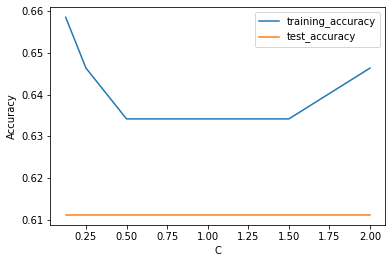

In [346]:
training_accuracy=[]
test_accuracy=[]

#Se harán 25 ciclos, cada uno para el parámetro estimadores
c_values = [0.125, 0.25, 0.5, 1.0, 1.5, 2.0]

for c in c_values:
  #construye el modelo
  svm= LinearSVC(C=c)
  svm.fit(trainData_pca, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(svm.score(trainData_pca, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(svm.score(testData_pca, testTarget))

plt.plot(c_values, training_accuracy, label= "training_accuracy")
plt.plot(c_values, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

**Este modelo esta totalmente Sub-Entrenado**

In [371]:

svm = LinearSVC(C=0.375)
svm.fit(trainData_pca, trainTarget)
print(classification_report(testTarget, svm.predict(testData_pca),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       0.59      0.72      0.65        18
      normal       0.64      0.50      0.56        18

    accuracy                           0.61        36
   macro avg       0.62      0.61      0.61        36
weighted avg       0.62      0.61      0.61        36



**Definitivamente PCA no es una buena opción para intentar clasificar imágenes, puesto que se pierden muchas caracteristicas al hacer la reducción de dimensionalidad**

***Binarización de los datos, inicialmente analizar complejidad dejando un valor constante para el numero de vecinos***

In [347]:
from sklearn.preprocessing import KBinsDiscretizer
bins= range(2,15)

train_score=[]
test_score=[]

for i in bins:
  print(f'Número de bins: {i}')
  #Se crea el objeto de clase KbinsDiscretizer
  kb = KBinsDiscretizer(n_bins=i, strategy='uniform', encode='onehot-dense')
  #Aprende la discretización con el dataset de entreno
  kb.fit(trainData)
  #Transformamos los dataset de entrenamiento y de test
  trainData_binned = kb.transform(trainData)
  testData_binned = kb.transform(testData)
  #Imprimimos los tamaños de los arreglos de las caracteristicas
  print(trainData_binned.shape)
  print(testData_binned.shape)
  #Creamos la nueva matriz de caracteristicas cómo un arreglo con las caracteristicas las originales y las mismas después de binning
  trainData_product = np.hstack([trainData,trainData_binned]) 
  testData_product = np.hstack([testData,testData_binned])
  #Imprimimos el tamaño de la nueva matriz de arreglos
  print(trainData_product.shape)
  print(testData_product.shape)

  # Entrenar Clasificador KNN
  
  #construye el modelo
  clf= KNeighborsClassifier(n_neighbors=4)
  clf.fit(trainData_product, trainTarget)
  #guardo el dato de precision
  train_score.append(clf.score(trainData_product, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_score.append(clf.score(testData_product, testTarget))

  print("Training set score: {:.2f}".format(clf.score(trainData_product, trainTarget)))
  print("Test set score: {:.2f}\n".format(clf.score(testData_product, testTarget)))

  

Número de bins: 2


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 773)
(36, 773)
(82, 1285)
(36, 1285)
Training set score: 0.83
Test set score: 0.97

Número de bins: 3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1034)
(36, 1034)
(82, 1546)
(36, 1546)
Training set score: 0.93
Test set score: 1.00

Número de bins: 4


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1295)
(36, 1295)
(82, 1807)
(36, 1807)
Training set score: 0.93
Test set score: 0.97

Número de bins: 5


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1556)
(36, 1556)
(82, 2068)
(36, 2068)
Training set score: 0.91
Test set score: 0.86

Número de bins: 6


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1817)
(36, 1817)
(82, 2329)
(36, 2329)
Training set score: 0.93
Test set score: 0.89

Número de bins: 7


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2078)
(36, 2078)
(82, 2590)
(36, 2590)
Training set score: 0.96
Test set score: 0.92

Número de bins: 8


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2339)
(36, 2339)
(82, 2851)
(36, 2851)
Training set score: 0.91
Test set score: 0.89

Número de bins: 9


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2600)
(36, 2600)
(82, 3112)
(36, 3112)
Training set score: 0.94
Test set score: 0.89

Número de bins: 10


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2861)
(36, 2861)
(82, 3373)
(36, 3373)
Training set score: 0.93
Test set score: 0.89

Número de bins: 11


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3122)
(36, 3122)
(82, 3634)
(36, 3634)
Training set score: 0.93
Test set score: 0.92

Número de bins: 12


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3383)
(36, 3383)
(82, 3895)
(36, 3895)
Training set score: 0.93
Test set score: 0.92

Número de bins: 13


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3644)
(36, 3644)
(82, 4156)
(36, 4156)
Training set score: 0.94
Test set score: 0.92

Número de bins: 14


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3905)
(36, 3905)
(82, 4417)
(36, 4417)
Training set score: 0.95
Test set score: 0.89



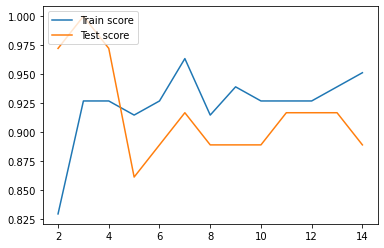

In [348]:
plt.plot(np.arange(2,15), train_score)
plt.plot(np.arange(2,15), test_score)
plt.legend(['Train score', 'Test score'], loc='upper left')
plt.show()

**Con 7 bins, el modelo de binarización Otorga el mejor resultado**

In [349]:
kb = KBinsDiscretizer(n_bins=7, strategy='uniform', encode='onehot-dense')
#Aprende la discretización con el dataset de entreno
kb.fit(trainData)
#Transformamos los dataset de entrenamiento y de test
trainData_binned = kb.transform(trainData)
testData_binned = kb.transform(testData)
#Imprimimos los tamaños de los arreglos de las caracteristicas
print(trainData_binned.shape)
print(testData_binned.shape)
#Creamos la nueva matriz de caracteristicas cómo un arreglo con las caracteristicas las originales y las mismas después de binning
trainData_product = np.hstack([trainData,trainData_binned]) 
testData_product = np.hstack([testData,testData_binned])
#Imprimimos el tamaño de la nueva matriz de arreglos
print(trainData_product.shape)
print(testData_product.shape)

# Entrenar Clasificador KNN

#construye el modelo
clf= KNeighborsClassifier(n_neighbors=4)
clf.fit(trainData_product, trainTarget)
print("Training set score: {:.2f}".format(clf.score(trainData_product, trainTarget)))
print("Test set score: {:.2f}\n".format(clf.score(testData_product, testTarget)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2078)
(36, 2078)
(82, 2590)
(36, 2590)
Training set score: 0.96
Test set score: 0.92



**KNN con Binarización, analisis de complejidad con el número de vecinos**

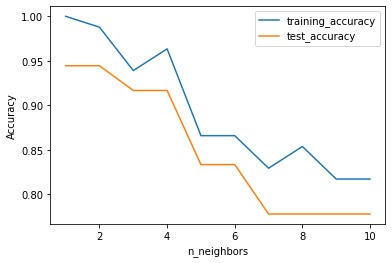

In [350]:
# Entrenar Clasificador

#Arreglos que almacenan resultados de las metricas
training_accuracy=[]
test_accuracy=[]

#va a hacer ciclos entre 1 y 10 vecinos
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
  #construye el modelo
  clf= KNeighborsClassifier(n_neighbors=n_neighbors)
  clf.fit(trainData_product, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(clf.score(trainData_product, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(clf.score(testData_product, testTarget))

plt.plot(neighbors_settings, training_accuracy, label= "training_accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

**Según el analisis de complejidad, el mejor parametro es con 2 vecinos**

In [351]:
clf_knn= KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(trainData_product, trainTarget)
print(classification_report(testTarget, clf_knn.predict(testData_product),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       1.00      0.89      0.94        18
      normal       0.90      1.00      0.95        18

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.94        36
weighted avg       0.95      0.94      0.94        36



**Utilizando Binarización se logra una precisión promedio de 95%, mejorando en 2 puntos porcentuales, la obtenida previamente sin ningun tipo de preprocesamiento de los vectores de caracteristicas**

**Binarización usando Regresión Logistica**

In [352]:
from sklearn.preprocessing import KBinsDiscretizer
bins= range(2,15)

train_score=[]
test_score=[]

for i in bins:
  print(f'Número de bins: {i}')
  #Se crea el objeto de clase KbinsDiscretizer
  kb = KBinsDiscretizer(n_bins=i, strategy='uniform', encode='onehot-dense')
  #Aprende la discretización con el dataset de entreno
  kb.fit(trainData)
  #Transformamos los dataset de entrenamiento y de test
  trainData_binned = kb.transform(trainData)
  testData_binned = kb.transform(testData)
  #Imprimimos los tamaños de los arreglos de las caracteristicas
  print(trainData_binned.shape)
  print(testData_binned.shape)
  #Creamos la nueva matriz de caracteristicas cómo un arreglo con las caracteristicas las originales y las mismas después de binning
  trainData_product = np.hstack([trainData,trainData_binned]) 
  testData_product = np.hstack([testData,testData_binned])
  #Imprimimos el tamaño de la nueva matriz de arreglos
  print(trainData_product.shape)
  print(testData_product.shape)

  # Entrenar Clasificador Regresion Logistica
  
  #construye el modelo
  logreg= LogisticRegression(C=3)
  logreg.fit(trainData_product, trainTarget)
  #guardo el dato de precision
  train_score.append(logreg.score(trainData_product, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_score.append(logreg.score(testData_product, testTarget))

  print("Training set score: {:.2f}".format(logreg.score(trainData_product, trainTarget)))
  print("Test set score: {:.2f}\n".format(logreg.score(testData_product, testTarget)))

Número de bins: 2
(82, 773)
(36, 773)
(82, 1285)
(36, 1285)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

Training set score: 0.96
Test set score: 0.97

Número de bins: 3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1034)
(36, 1034)
(82, 1546)
(36, 1546)
Training set score: 1.00
Test set score: 0.94

Número de bins: 4


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1295)
(36, 1295)
(82, 1807)
(36, 1807)
Training set score: 1.00
Test set score: 0.97

Número de bins: 5


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant a

(82, 1556)
(36, 1556)
(82, 2068)
(36, 2068)
Training set score: 1.00
Test set score: 0.97

Número de bins: 6


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1817)
(36, 1817)
(82, 2329)
(36, 2329)
Training set score: 1.00
Test set score: 1.00

Número de bins: 7


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant a

(82, 2078)
(36, 2078)
(82, 2590)
(36, 2590)
Training set score: 1.00
Test set score: 0.97

Número de bins: 8


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2339)
(36, 2339)
(82, 2851)
(36, 2851)
Training set score: 1.00
Test set score: 0.97

Número de bins: 9


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2600)
(36, 2600)
(82, 3112)
(36, 3112)
Training set score: 1.00
Test set score: 0.97

Número de bins: 10


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2861)
(36, 2861)
(82, 3373)
(36, 3373)
Training set score: 1.00
Test set score: 1.00

Número de bins: 11


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3122)
(36, 3122)
(82, 3634)
(36, 3634)
Training set score: 1.00
Test set score: 1.00

Número de bins: 12


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3383)
(36, 3383)
(82, 3895)
(36, 3895)
Training set score: 1.00
Test set score: 1.00

Número de bins: 13


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant a

(82, 3644)
(36, 3644)
(82, 4156)
(36, 4156)
Training set score: 1.00
Test set score: 0.97

Número de bins: 14


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant a

(82, 3905)
(36, 3905)
(82, 4417)
(36, 4417)
Training set score: 1.00
Test set score: 0.97



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


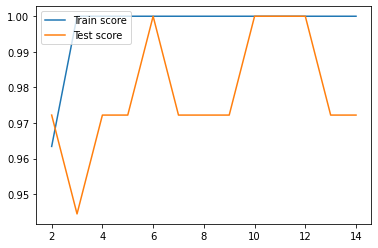

In [353]:
plt.plot(np.arange(2,15), train_score)
plt.plot(np.arange(2,15), test_score)
plt.legend(['Train score', 'Test score'], loc='upper left')
plt.show()

**El mejor resultado es usando 6 bins**

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1817)
(36, 1817)
(82, 2329)
(36, 2329)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


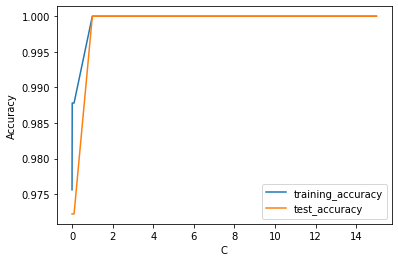

In [354]:
kb = KBinsDiscretizer(n_bins=6, strategy='uniform', encode='onehot-dense')
#Aprende la discretización con el dataset de entreno
kb.fit(trainData)
#Transformamos los dataset de entrenamiento y de test
trainData_binned = kb.transform(trainData)
testData_binned = kb.transform(testData)
#Imprimimos los tamaños de los arreglos de las caracteristicas
print(trainData_binned.shape)
print(testData_binned.shape)
#Creamos la nueva matriz de caracteristicas cómo un arreglo con las caracteristicas las originales y las mismas después de binning
trainData_product = np.hstack([trainData,trainData_binned]) 
testData_product = np.hstack([testData,testData_binned])
#Imprimimos el tamaño de la nueva matriz de arreglos
print(trainData_product.shape)
print(testData_product.shape)


# Entrenar Clasificador Regresión Logistica

#Arreglos que almacenan resultados de las metricas
training_accuracy=[]
test_accuracy=[]

#Se harán 4 ciclos, cada uno para el parámetro C
c_settings = [0.001, 0.01, 0.1, 1, 5, 10, 15]

for c in c_settings:
  #construye el modelo
  logreg= LogisticRegression(C=c)
  logreg.fit(trainData_product, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(logreg.score(trainData_product, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(logreg.score(testData_product, testTarget))

plt.plot(c_settings, training_accuracy, label= "training_accuracy")
plt.plot(c_settings, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

**Con el parametro C igual a 1 se logra un 100% de precision (quizas sea un exceso de regularización)**

In [355]:
logreg= LogisticRegression(C=1)
logreg.fit(trainData_product, trainTarget)
print(classification_report(testTarget, logreg.predict(testData_product),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       1.00      1.00      1.00        18
      normal       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



**Como se muestra, se logra una precisión del 100% de los datos**

****Binarización usando Bosques Aleatorios****

In [356]:
from sklearn.preprocessing import KBinsDiscretizer
bins= range(2,15)

train_score=[]
test_score=[]

for i in bins:
  print(f'Número de bins: {i}')
  #Se crea el objeto de clase KbinsDiscretizer
  kb = KBinsDiscretizer(n_bins=i, strategy='uniform', encode='onehot-dense')
  #Aprende la discretización con el dataset de entreno
  kb.fit(trainData)
  #Transformamos los dataset de entrenamiento y de test
  trainData_binned = kb.transform(trainData)
  testData_binned = kb.transform(testData)
  #Imprimimos los tamaños de los arreglos de las caracteristicas
  print(trainData_binned.shape)
  print(testData_binned.shape)
  #Creamos la nueva matriz de caracteristicas cómo un arreglo con las caracteristicas las originales y las mismas después de binning
  trainData_product = np.hstack([trainData,trainData_binned]) 
  testData_product = np.hstack([testData,testData_binned])
  #Imprimimos el tamaño de la nueva matriz de arreglos
  print(trainData_product.shape)
  print(testData_product.shape)

  # Entrenar Clasificador Arboles de decision

  #construye el modelo
  forest= RandomForestClassifier(n_estimators=25, max_features=trainData_product.shape[1], random_state=84)
  forest.fit(trainData_product, trainTarget)

  #guardo el dato de precision
  train_score.append(forest.score(trainData_product, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_score.append(forest.score(testData_product, testTarget))

  print("Training set score: {:.2f}".format(forest.score(trainData_product, trainTarget)))
  print("Test set score: {:.2f}\n".format(forest.score(testData_product, testTarget)))

Número de bins: 2
(82, 773)
(36, 773)
(82, 1285)
(36, 1285)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

Training set score: 1.00
Test set score: 0.97

Número de bins: 3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1034)
(36, 1034)
(82, 1546)
(36, 1546)
Training set score: 1.00
Test set score: 1.00

Número de bins: 4


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1295)
(36, 1295)
(82, 1807)
(36, 1807)
Training set score: 1.00
Test set score: 0.94

Número de bins: 5


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1556)
(36, 1556)
(82, 2068)
(36, 2068)
Training set score: 1.00
Test set score: 0.97

Número de bins: 6


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1817)
(36, 1817)
(82, 2329)
(36, 2329)
Training set score: 1.00
Test set score: 1.00

Número de bins: 7


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2078)
(36, 2078)
(82, 2590)
(36, 2590)
Training set score: 1.00
Test set score: 0.94

Número de bins: 8


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2339)
(36, 2339)
(82, 2851)
(36, 2851)
Training set score: 1.00
Test set score: 0.97

Número de bins: 9


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2600)
(36, 2600)
(82, 3112)
(36, 3112)
Training set score: 1.00
Test set score: 0.94

Número de bins: 10


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 2861)
(36, 2861)
(82, 3373)
(36, 3373)
Training set score: 1.00
Test set score: 0.97

Número de bins: 11


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3122)
(36, 3122)
(82, 3634)
(36, 3634)
Training set score: 1.00
Test set score: 0.97

Número de bins: 12


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3383)
(36, 3383)
(82, 3895)
(36, 3895)
Training set score: 1.00
Test set score: 1.00

Número de bins: 13


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3644)
(36, 3644)
(82, 4156)
(36, 4156)
Training set score: 1.00
Test set score: 0.97

Número de bins: 14


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 3905)
(36, 3905)
(82, 4417)
(36, 4417)
Training set score: 1.00
Test set score: 0.97



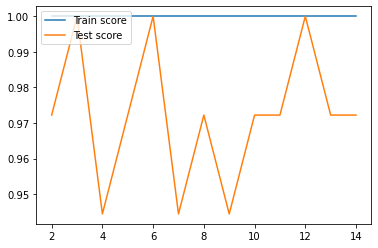

In [357]:
plt.plot(np.arange(2,15), train_score)
plt.plot(np.arange(2,15), test_score)
plt.legend(['Train score', 'Test score'], loc='upper left')
plt.show()

**El mejor parámetro es usar 3 bins**

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1034)
(36, 1034)
(82, 1546)
(36, 1546)


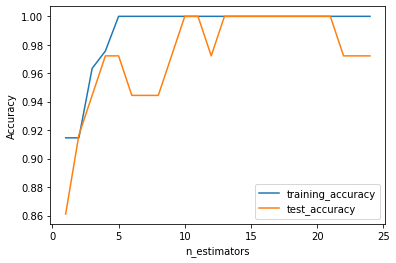

In [358]:
kb_forest = KBinsDiscretizer(n_bins=3, strategy='uniform', encode='onehot-dense')
#Aprende la discretización con el dataset de entreno
kb_forest.fit(trainData)
#Transformamos los dataset de entrenamiento y de test
trainData_binned = kb_forest.transform(trainData)
testData_binned = kb_forest.transform(testData)
#Imprimimos los tamaños de los arreglos de las caracteristicas
print(trainData_binned.shape)
print(testData_binned.shape)
#Creamos la nueva matriz de caracteristicas cómo un arreglo con las caracteristicas las originales y las mismas después de binning
trainData_product = np.hstack([trainData,trainData_binned]) 
testData_product = np.hstack([testData,testData_binned])
#Imprimimos el tamaño de la nueva matriz de arreglos
print(trainData_product.shape)
print(testData_product.shape)


training_accuracy=[]
test_accuracy=[]

#Se harán 25 ciclos, cada uno para el parámetro estimadores
n_estimators = range(1, 25)

for c in n_estimators:
  #construye el modelo
  forest_bin= RandomForestClassifier(n_estimators=c, max_features=trainData_product.shape[1], random_state=84)
  forest_bin.fit(trainData_product, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(forest_bin.score(trainData_product, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(forest_bin.score(testData_product, testTarget))

plt.plot(n_estimators, training_accuracy, label= "training_accuracy")
plt.plot(n_estimators, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()

**Con 10 Estimadores se logra la mayor precisión**

In [359]:
forest= RandomForestClassifier(n_estimators=10, max_features=trainData_product.shape[1], random_state=84)
forest.fit(trainData_product, trainTarget)
print(classification_report(testTarget, forest.predict(testData_product),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       1.00      1.00      1.00        18
      normal       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



**Iguualmente se logra obtener un modelo con 100% de precisión**

**Binarización con Máquina de Soporte Vectorial**

In [360]:
from sklearn.preprocessing import KBinsDiscretizer
bins= range(2,15)

train_score=[]
test_score=[]

for i in bins:
  print(f'Número de bins: {i}')
  #Se crea el objeto de clase KbinsDiscretizer
  kb = KBinsDiscretizer(n_bins=i, strategy='uniform', encode='onehot-dense')
  #Aprende la discretización con el dataset de entreno
  kb.fit(trainData)
  #Transformamos los dataset de entrenamiento y de test
  trainData_binned = kb.transform(trainData)
  testData_binned = kb.transform(testData)
  #Imprimimos los tamaños de los arreglos de las caracteristicas
  print(trainData_binned.shape)
  print(testData_binned.shape)
  #Creamos la nueva matriz de caracteristicas cómo un arreglo con las caracteristicas las originales y las mismas después de binning
  trainData_product = np.hstack([trainData,trainData_binned]) 
  testData_product = np.hstack([testData,testData_binned])
  #Imprimimos el tamaño de la nueva matriz de arreglos
  print(trainData_product.shape)
  print(testData_product.shape)

  # Entrenar Clasificador SVM
  
  #construye el modelo
  svm = LinearSVC(C=0.375)
  svm.fit(trainData_product, trainTarget)
  #guardo el dato de precision
  train_score.append(svm.score(trainData_product, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_score.append(svm.score(testData_product, testTarget))

  print("Training set score: {:.2f}".format(svm.score(trainData_product, trainTarget)))
  print("Test set score: {:.2f}\n".format(svm.score(testData_product, testTarget)))

Número de bins: 2


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 773)
(36, 773)
(82, 1285)
(36, 1285)
Training set score: 0.96
Test set score: 0.94

Número de bins: 3


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 1034)
(36, 1034)
(82, 1546)
(36, 1546)
Training set score: 1.00
Test set score: 0.94

Número de bins: 4


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 1295)
(36, 1295)
(82, 1807)
(36, 1807)
Training set score: 1.00
Test set score: 0.94

Número de bins: 5


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 1556)
(36, 1556)
(82, 2068)
(36, 2068)
Training set score: 1.00
Test set score: 0.94

Número de bins: 6


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 1817)
(36, 1817)
(82, 2329)
(36, 2329)
Training set score: 1.00
Test set score: 1.00

Número de bins: 7


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 2078)
(36, 2078)
(82, 2590)
(36, 2590)
Training set score: 1.00
Test set score: 0.97

Número de bins: 8


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 2339)
(36, 2339)
(82, 2851)
(36, 2851)
Training set score: 1.00
Test set score: 0.97

Número de bins: 9


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 2600)
(36, 2600)
(82, 3112)
(36, 3112)
Training set score: 1.00
Test set score: 0.97

Número de bins: 10


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 2861)
(36, 2861)
(82, 3373)
(36, 3373)
Training set score: 1.00
Test set score: 0.97

Número de bins: 11


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 3122)
(36, 3122)
(82, 3634)
(36, 3634)
Training set score: 1.00
Test set score: 1.00

Número de bins: 12


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 3383)
(36, 3383)
(82, 3895)
(36, 3895)
Training set score: 1.00
Test set score: 1.00

Número de bins: 13


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 3644)
(36, 3644)
(82, 4156)
(36, 4156)
Training set score: 1.00
Test set score: 0.97

Número de bins: 14


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarnin

(82, 3905)
(36, 3905)
(82, 4417)
(36, 4417)
Training set score: 1.00
Test set score: 0.97



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


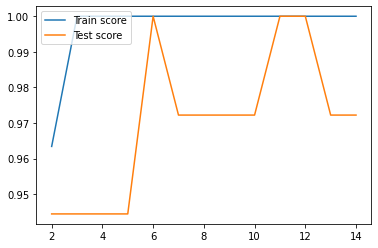

In [361]:
plt.plot(np.arange(2,15), train_score)
plt.plot(np.arange(2,15), test_score)
plt.legend(['Train score', 'Test score'], loc='upper left')
plt.show()

**Con 6 bins se logra una precisión del 100%**

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 3 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 4 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 5 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 6 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 7 is constant and will be replaced with 0.
  "replaced with 0." % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:163: UserWarning: Feature 12 is constant

(82, 1817)
(36, 1817)
(82, 2329)
(36, 2329)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

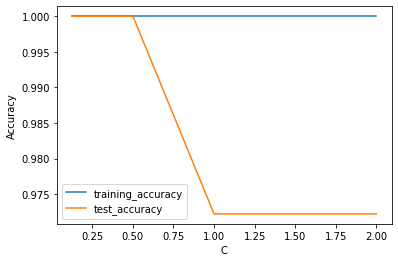

In [362]:
kb = KBinsDiscretizer(n_bins=6, strategy='uniform', encode='onehot-dense')
#Aprende la discretización con el dataset de entreno
kb.fit(trainData)
#Transformamos los dataset de entrenamiento y de test
trainData_binned = kb.transform(trainData)
testData_binned = kb.transform(testData)
#Imprimimos los tamaños de los arreglos de las caracteristicas
print(trainData_binned.shape)
print(testData_binned.shape)
#Creamos la nueva matriz de caracteristicas cómo un arreglo con las caracteristicas las originales y las mismas después de binning
trainData_product = np.hstack([trainData,trainData_binned]) 
testData_product = np.hstack([testData,testData_binned])
#Imprimimos el tamaño de la nueva matriz de arreglos
print(trainData_product.shape)
print(testData_product.shape)


training_accuracy=[]
test_accuracy=[]

#Se harán 6 ciclos, cada uno para el parámetro c
c_values = [0.125, 0.25, 0.5, 1.0, 1.5, 2.0]

for c in c_values:
  #construye el modelo
  svm= LinearSVC(C=c)
  svm.fit(trainData_product, trainTarget)
  #guardo el dato de precision
  training_accuracy.append(svm.score(trainData_product, trainTarget))
  # guarda la precision en la generalizacion que se hace con los datos de test
  test_accuracy.append(svm.score(testData_product, testTarget))

plt.plot(c_values, training_accuracy, label= "training_accuracy")
plt.plot(c_values, test_accuracy, label="test_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()

**Para un C igual a 0.125 se obtiene el mejor resultado de precisión, siendo del 100%**

In [363]:
svm= LinearSVC(C=0.125)
svm.fit(trainData_product, trainTarget)
print(classification_report(testTarget, svm.predict(testData_product),
    target_names = targetNames))

              precision    recall  f1-score   support

     mineria       1.00      1.00      1.00        18
      normal       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



**Como se observó en todos los casos, la binarización logró mejorar notablemente el rendimiento de cada uno de los 4 modelos de Aprendizaje Automático usados en este proyecto**

**Predicciones con Binarización en Random Forest**

Features shape:  (1, 1546)
Esta imagen satelital es de NORMAL


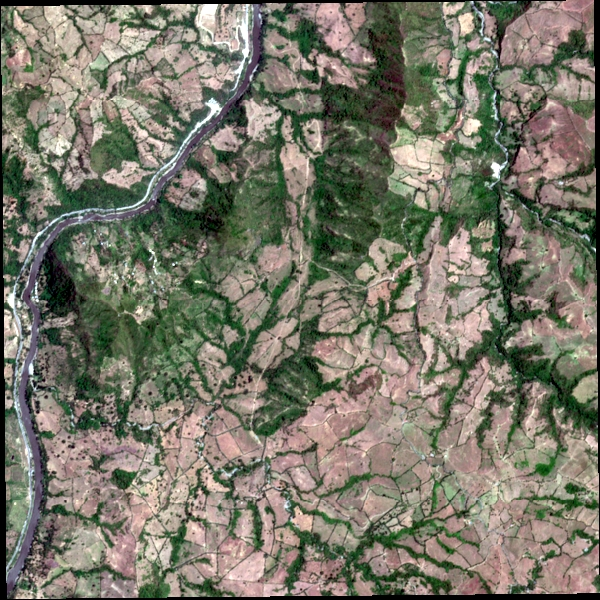

In [364]:
from google.colab.patches import cv2_imshow
# load the image and mask  (83.jpg)
image = cv2.imread("/content/gdrive/My Drive/Proyecto_Final_ML/test/83.jpg")
# Create new blank 300x300 red image
width1, height1 = image.shape[:2]

color = (255, 255, 255)
mask = create_blank(width1, height1, rgb_color=color)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# Caracteristicas originales (histograma)
features = [desc.describe(image, mask)]

# Binarizar Caracteristicas
features_binned = kb_forest.transform(features)
# Unir caracteristicas binarizadas y las originales
features_product = np.hstack([features,features_binned]) 

print("Features shape: ", np.shape(features_product))

# Predecir que categoria es detectada
mineria = le.inverse_transform(forest_bin.predict(features_product))[0]
print("Esta imagen satelital es de {}".format(mineria.upper()))
cv2_imshow(image)


**Se concluye que evidentemente hacer ingeniería de caracteristicas es claramente una excelente forma de mejorar el rendimiento de los modelos, en este caso, usar binarización enriquecio con 1034 caracteristicas nuevas, lo que permitió reconocer de forma más precisa la imagen**